<a href="https://colab.research.google.com/github/DKhan1998/Prediction-Model/blob/master/CS_GO_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
# Load the TensorBoard notebook extension.
%load_ext tensorboard

!pip uninstall keras

# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

# Import keras to use the callback function to analyse model
!pip install -q git+https://github.com/keras-team/keras.git

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? 

In [ ]:
import sys;
import tensorflow as tf

#Version 1 libraries for sequential model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from IPython.display import display

#necesseray libraries for version 2 of the model.
import xgboost as xgb
import pathlib
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from sklearn.metrics import f1_score


# Tensorboard libraries
import tensorboard
from datetime import datetime
from packaging import version
from tensorboard import notebook
notebook.list() # View opened TensorBoard instances

# Upload Dataset to Pandas DataFrame

In [ ]:
# Open database
from google.colab import files
uploaded = files.upload()

Saving Players Dataset.csv to Players Dataset.csv


In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Players Dataset.csv']))
# Dataset is now stored in a Pandas Dataframe

# VISUALISING DISTRIBUTION OF DATA

The scatter matrix plots each of the specified coloums against each other column. 

Scatter plots show how much one variable is affected by another.
The relationship between two variables is called the correlation.
negative vs positive correlation

FTR = Final Time Results (W = Win, D = Draw, L = Loss)

KPG = Kills Per Game

DPG = Deaths Per Game

KDR = Kills Deaths Ratio

FPR = Frags Per Round

ADR = Average Damage per Round


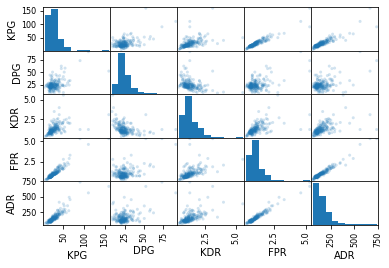

In [ ]:
## Separate the input and output features; Version 1 of model

x = df2.drop(columns=['FTR'])
y = df2['FTR']

#Standarising the data. - Version 2 model
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance - improves prediction capability
cols = [['KPG', 'DPG', 'KDR', 'FPR', 'ADR']]
for col in cols:
  x[col] = scale(x[col])

# Use the scatter matrix to display the datset and correlation between features.
  scatter_matrix(df2, alpha=0.2)

#Preproccessing DataFrame

In [ ]:
'''# identifies datatypes in the dataset '''
df2.dtypes

# Create a new dataset to pass
def preprocess_features(df2):

  # Initialize new Dataframe
  output = pd.DataFrame(index= df2.index)

  # Investigate the nature of each feature column
  for col, col_data in df2.iteritems():

    #If data type is categorical, convert it to dummy data
    # Using One Hot Encoding we have created 3 new columns with an integer assign 
    if col_data.dtypes == object:
      col_data = pd.get_dummies(col_data, prefix= col)

    # Collect the revised columns of the dataset
    output = output.join(col_data)

  return output

x = preprocess_features(df2)

# Shuffles the given dataset
df2 = shuffle(x, random_state=2)

df2.head()


,FTR_D,FTR_L,FTR_W,KPG,DPG,KDR,FPR,ADR
64,0,0,1,23,21,1.1,1.0,169
9,0,0,1,37,14,2.6,1.9,227
97,0,0,1,20,20,1.0,0.8,113
203,0,0,1,14,20,0.7,0.5,75
35,0,1,0,37,29,1.3,1.4,169


#Splitting DataFrame 80% / 20%

In [ ]:
# split data into training and testing data

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 80, random_state = 2, stratify = y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((129, 8), (129,), (80, 8), (80,))

# Setting logs directory  for Tensorboard

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Version 1 of Prediction Model - Sequential

In [ ]:
''' Version 1 of Prediction Model, Produced unsatisfactory results.

#define a sequential model
model = Sequential()

#hidden layer-1 
model.add(Dense(100, activation='relu', input_dim=5, kernel_regularizer=l2(0.01
)))
model.add(Dropout(0.3, seed=None))

#hidden layer-2 
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01
)))
model.add(Dropout(0.3, seed=None))

#Output layer
model.add(Dense(1, activation='sigmoid')) 

# Compile the model with the following metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Shows you a summary of the model crafted.
model.summary()
'''

" Version 1 of Prediction Model, Produced unsatisfactory results.\n\n#define a sequential model\nmodel = Sequential()\n\n#hidden layer-1 \nmodel.add(Dense(100, activation='relu', input_dim=5, kernel_regularizer=l2(0.01\n)))\nmodel.add(Dropout(0.3, seed=None))\n\n#hidden layer-2 \nmodel.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01\n)))\nmodel.add(Dropout(0.3, seed=None))\n\n#Output layer\nmodel.add(Dense(1, activation='sigmoid')) \n\n# Compile the model with the following metrics\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])\n\n# Shows you a summary of the model crafted.\nmodel.summary()\n"

In [ ]:
''' Training Version 1 o rediction model 

model_output = model.fit(x_train, y_train, epochs=500, batch_size=20, verbose=1, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

print('training Accuracy : ', np.mean(model_output.history['acc']))
print('Validation Accuracy : ', np.mean(model_output.history['val_acc'])) '''

" Training Version 1 o rediction model \n\nmodel_output = model.fit(x_train, y_train, epochs=500, batch_size=20, verbose=1, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])\n\nprint('training Accuracy : ', np.mean(model_output.history['acc']))\nprint('Validation Accuracy : ', np.mean(model_output.history['val_acc'])) "

# Version 2 of Prediction Model - 3 in 1

In [ ]:
#@title Default title text
def train_classifier(clf, x_train, y_train):
  ''' Fits a classifier to the training data '''

  # Start the clock, train the classifier, then stop the clock
  start = tf.timestamp()
  history = clf.fit(x_train, y_train)
  end = tf.timestamp()

  #Print the results
  print ('Trained model in {:.4f} seconds'.format(end - start))

def predict_labels(clf, features, target):
  ''' Makes predictions using a fit classfier based on f1 score and accuracy ''' 

  pos_label = 'W'

  # Start the clock, make predictions, then stop the clock
  start = tf.timestamp()
  y_pred = clf.predict(features)
  end = tf.timestamp()

  # Print and return results
  print ('Made predictions in {:.4f} seconds'.format(end-start))
  score = f1_score(target, y_pred, labels=[pos_label], average='micro', zero_division='warn')
  print (score)
  return score

def train_predict(clf, x_train, y_train, x_test, y_test):
  ''' Train and predict using a classifier based on an F1 score '''

  # Train the classifier
  train_classifier(clf, x_train, y_train)

  #Print the results of prediction for both trainign and testing
  f1 = predict_labels(clf, x_train, y_train)

  f1 = predict_labels(clf, x_test, y_test)



In [ ]:
''' Version 2 of prediction model uses 3 different models to test which one is more dominant in outcome
    In this section a test is conducted to see which model perfomrs the best in this type of data with
    the following 3 models         '''

# Defining the types of model to run test on
clf_A = Logist
#necesseray libraries for version 2icRegression(random_state= 42)
clf_B = SVC(random_state= 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)

LG_T = train_predict(clf_A, x_train, y_train, x_test, y_test)
print ()

SVM_T = train_predict(clf_B, x_train, y_train, x_test, y_test)
print ()

XGB_T = train_predict(clf_C, x_train, y_train, x_test, y_test)
print ()

Trained model in 0.0364 seconds
Made predictions in 0.0012 seconds
0.743455497382199
Made predictions in 0.0010 seconds
0.7154471544715447

Trained model in 0.0032 seconds
Made predictions in 0.0014 seconds
0.7425742574257426
Made predictions in 0.0012 seconds
0.7401574803149606

Trained model in 0.0366 seconds
Made predictions in 0.0033 seconds
0.9548387096774195
Made predictions in 0.0021 seconds
0.6796116504854368



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Tensorboard analysis 

In [ ]:
%tensorboard --logdir logs/scalars/

UsageError: Line magic function `%tensorboard` not found.
